In [24]:
#variedad
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import interp
import plotly
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import re
import nltk
import mlxtend  
from collections import Counter
import warnings
from itertools import cycle
from yellowbrick.text import TSNEVisualizer
import pickle
from pickle import dump
from numpy import sqrt
from numpy import argmax
from matplotlib import pyplot
import seaborn as sns

#Separar datos
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.model_selection import KFold


#modelos
from sklearn.tree import DecisionTreeClassifier         # Arbol decisión
from sklearn.naive_bayes import GaussianNB              # Naive bayes
from sklearn.linear_model import LogisticRegression     # Logística con regularización
from sklearn.svm import SVC                             # Maquina de vector de soportes
from sklearn.model_selection import StratifiedKFold
from sklearn import svm

#tf-df
from sklearn.feature_extraction.text import TfidfVectorizer

#metricas
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn import metrics
from sklearn.metrics import  classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from yellowbrick.model_selection import LearningCurve
from sklearn.model_selection import learning_curve
from yellowbrick.classifier import ClassificationReport
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [31]:
#Leer base madre
df = pd.read_csv('tweets_base_madre.csv', encoding ='utf-8')
df.head()

,created_at,id,user id,full_text,localidad,retweet_count,favorite_count,clasification,tidy_text
0,12/10/2020 01:31,1.320000e+18,9.884670e+17,Slim es de los principales beneficiados por AM...,"Xochimilco, Distrito Federal",0,0,1.0,slim principales beneficiados amlo siempre mas...
1,12/10/2020 02:30,1.320000e+18,1.147230e+18,¡ESTO NO LO VISTE DE @lopezobrador_ EN VERDAD...,Aquí! en mi México Querido.,0,0,0.0,viste @lopezobrador_ verdad ll0ro dar mensaje ...
2,19/10/2020 12:08,1.320000e+18,1.102780e+18,▶️ Sigue la conferencia diaria del presidente ...,"Querétaro, Querétaro Arteaga",0,0,2.0,▶️ sigue conferencia diaria presidente lopez o...
3,19/10/2020 12:08,1.320000e+18,2.374583e+09,#EnPortada | Ante represión violenta en Tabasc...,Ciudad de México,0,0,2.0,#enportada represion violenta tabasco amlo: pr...
4,19/10/2020 12:08,1.320000e+18,1.204230e+18,@Vale___Mx @PartidoMorenaMx Por eso de que vot...,NaN,0,0,1.0,@vale___mx @partidomorenamx voto masivo morena...


In [26]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(y_test,y_scores,nombre, model, p, r, thresholds, t):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    #print(y_test)
    #print(y_pred_adj)
    #print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
    #                   columns=['pred_neg', 'pred_pos'], 
    #                   index=['neg', 'pos']))
    matrix = pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos'])
    matrix = np.array(matrix)
    #print(type(matrix))
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

    return matrix
    
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.show()

def prediccionesModelo(modelo,Test_X_Tfidf,Test_Y, nombre):
    with warnings.catch_warnings():
        # ignore all caught warnings
        warnings.filterwarnings("ignore")
        # execute code that will generate warnings
        predicciones = modelo.predict(Test_X_Tfidf)
        print(classification_report(Test_Y,predicciones))
        classes = ["Liberales", "Conservadores"]
        visualizer = ClassificationReport(modelo, classes=classes, support=True, cmap='PuOr')
        visualizer.score(Test_X_Tfidf, Test_Y)        # Evaluate the model on the test data
        plt.show()                       # Finalize and show the figure
    return predicciones

def curvaRocAuc(Test_Y,predicciones):
    # y_true must be your labels
    fpr, tpr, thresholds = metrics.roc_curve(Test_Y, predicciones, pos_label=None)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva roc-auc modelSVC')
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.show()

def curvaRocAucSalida(Test_Y,predicciones,clase):
    with warnings.catch_warnings():
        # ignore all caught warnings
        warnings.filterwarnings("ignore")
        # execute code that will generate warnings
        import plotly.graph_objs as go
        n_classes = len(np.unique(Test_Y))
        #print(n_classes)
        # y_true must be your labels
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], thresholds = metrics.roc_curve(Test_Y, predicciones, i)
            roc_auc[i] = metrics.auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(Test_Y.ravel(), predicciones.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        #print(roc_auc)

        lw = 2

        trace1 = go.Scatter(x=fpr[1], y=tpr[1], 
                            mode='lines', 
                            line=dict(color='darkorange', width=lw),
                            name='ROC curve (area = %0.2f)' % roc_auc[clase]
                           )

        trace2 = go.Scatter(x=[0, 1], y=[0, 1], 
                            mode='lines', 
                            line=dict(color='navy', width=lw, dash='dash'),
                            showlegend=False)

        layout = go.Layout(title='Receiver operating characteristic example',
                           xaxis=dict(title='False Positive Rate'),
                           yaxis=dict(title='True Positive Rate'))

        fig = go.Figure(data=[trace1, trace2], layout=layout)
        fig.show()

def curvasRocAucSalida(Test_Y,predicciones, nombre):
    with warnings.catch_warnings():
        # ignore all caught warnings
        warnings.filterwarnings("ignore")
        # execute code that will generate warnings
        import plotly.graph_objs as go
        n_classes = len(np.unique(Test_Y))
        #print(n_classes)
        # y_true must be your labels
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], thresholds = metrics.roc_curve(Test_Y, predicciones, i)
            roc_auc[i] = metrics.auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(Test_Y.ravel(), predicciones.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        #print(roc_auc)

        lw = 2
        
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        
        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        
        # Plot all ROC curves
        data = []
        trace1 = go.Scatter(x=fpr["micro"], y=tpr["micro"],
                            mode='lines', 
                            line=dict(color='deeppink', width=lw, dash='dot'),
                            name='micro-average ROC curve (area = {0:0.2f})'
                                   ''.format(roc_auc["micro"]))
        data.append(trace1)

        trace2 = go.Scatter(x=fpr["macro"], y=tpr["macro"],
                            mode='lines', 
                            line=dict(color='navy', width=lw, dash='dot'),
                            name='macro-average ROC curve (area = {0:0.2f})'
                                  ''.format(roc_auc["macro"]))
        data.append(trace2)
        
        colors = cycle(['aqua', 'darkorange'])
        for i, color in zip(range(n_classes), colors):
            trace3 = go.Scatter(x=fpr[i], y=tpr[i],
                                mode='lines', 
                                line=dict(color=color, width=lw),
                                name='ROC curve of class {0} (area = {1:0.2f})'
                                ''.format(i, roc_auc[i]))
            data.append(trace3)

        trace4 = go.Scatter(x=[0, 1], y=[0, 1], 
                            mode='lines', 
                            line=dict(color='black', width=lw, dash='dash'),
                            showlegend=False)
        data.append(trace4)
        layout = go.Layout(title='Some extension of Receiver operating characteristic to multi-class',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'))

        fig = go.Figure(data=data, layout=layout)
        fig.write_html('rocauc' + "".join(nombre) + ".html")
        fig.show()

def plot_confusion_matrixPlt(model,Test_X_Tfidf,Test_Y):
    from sklearn.metrics import plot_confusion_matrix
    # Plot non-normalized confusion matrix
    title = "Matriz de confusion"
    class_names = np.unique(Test_Y)
    #class_names = [df.clasification]
    disp = plot_confusion_matrix(model, Test_X_Tfidf, Test_Y, display_labels=class_names, cmap=plt.cm.Blues)
    #disp.ax_.set_title(title)
    plt.close()
    #print(title)
    #print(disp.confusion_matrix)

    #plt.show()
    print(disp.confusion_matrix)
    print(type(disp.confusion_matrix))
    return disp

def plot_confusion_matrix(y_true, y_pred, class_names, zl, nombre):
    import plotly.figure_factory as ff
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    confusion_matrix = confusion_matrix.astype(int)
        
    x = class_names
    y = class_names
    z = zl
    
    z_text = zl
    
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, 
                                      colorscale=[[0, "rgb(102,102,102)"],
                                                  [0.5, "rgb(117,112,179)"],
                                                  [1, "rgb(230,171,2)"]])
    fig.update_layout(title_text='Confusion Matrix')
    # add custom xaxis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=0.5,
                            y=-0.15,
                            showarrow=False,
                            text="Predicted value",
                            xref="paper",
                            yref="paper"))

    # add custom yaxis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=-0.15,
                            y=0.5,
                            showarrow=False,
                            text="Real value",
                            textangle=-90,
                            xref="paper",
                            yref="paper"))

    # adjust margins to make room for yaxis title
    fig.update_layout(margin=dict(t=50, l=100))

    # add colorbar
    fig['data'][0]['showscale'] = True
    fig.write_html("matriz" + "".join(nombre) + '.html')
    fig.show()

#funcion que limpia los tweets
def cleanTxt(text):
    # Cambia texto a minusculas
    text = text.lower()
    text = re.sub(r'@', '', text) #quita las @menciones
    text = re.sub(r'#', '', text) #quita los # simbolos
    text = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+','',text) #quita los hyper textos
    # Expresiones regulares para remplazar simbolos por espacios 
    text = re.sub('[\n(){}\[\]\|,;\"\“\”\‘\’\'\«\»!¡?¿]', '', text)
    # Elimina Manejo de puntos suspensivos
    text = re.sub('\.[\.]+', '', text)
    # Elimina Manejo de caracteres aislados
    text = re.sub('\s.\s', '', text)
    # Elimina Manejo de números aislados
    text = re.sub('\s[0-9]+\s', '', text)
    # Elimina Manejo de fechas
    text = re.sub('\d\d/\d\d/\d\d|\d\d/\d\d/\d\d\d\d', '', text)
    # Se establece token de risa
    text = re.sub(r'\s([jJ][AaEeIi])+\s', r' <risa> ', text)
    text = re.sub(r'(ja|je|ji|JA|JE|JI|\s a|\s e|\s i)([jJ][AaEeIi])(\w?)', r' <risa> ', text)
    text = re.sub(r'\s((ha|Ha|he|HE)[hH][AaEeIi])+\w', r' <risa> ', text)
    return text

def separaData(df,nombreCol,tam):
    Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df[nombreCol],df['clasification'],test_size=tam)
    
    Encoder = LabelEncoder()
    Train_Y = Encoder.fit_transform(Train_Y)
    Test_Y = Encoder.fit_transform(Test_Y)
    
    Tfidf_vect = TfidfVectorizer(max_features=None, ngram_range = (1,3), max_df = 0.9, min_df = 5)
    Tfidf_vect.fit(df[nombreCol])
    Train_X_Tfidf = Tfidf_vect.transform(Train_X)
    Test_X_Tfidf = Tfidf_vect.transform(Test_X)
    #print(Tfidf_vect.vocabulary_)
    len(Tfidf_vect.vocabulary_)
    return Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y, Tfidf_vect

def GraficaData(df,nombreCol):
    with warnings.catch_warnings():
        # ignore all caught warnings
        warnings.filterwarnings("ignore")
        # execute code that will generate warnings
        Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df[nombreCol],df['clasification'],test_size=1)
        y = Train_Y
        Encoder = LabelEncoder()
        Train_Y = Encoder.fit_transform(Train_Y)
        Test_Y = Encoder.fit_transform(Test_Y)

        Tfidf_vect = TfidfVectorizer(max_features=None, ngram_range = (1,3), max_df = 0.9, min_df = 5)
        Tfidf_vect.fit(df[nombreCol])

        Train_X_Tfidf = Tfidf_vect.transform(Train_X)
        Test_X_Tfidf = Tfidf_vect.transform(Test_X)
        #print(Tfidf_vect.vocabulary_)
        len(Tfidf_vect.vocabulary_)
        #print(Train_X_Tfidf)
        warnings.filterwarnings("ignore")
        tsne = TSNEVisualizer(cmap='PuOr')
        warnings.filterwarnings("ignore")
        tsne.fit(Train_X_Tfidf, y)
        warnings.filterwarnings("ignore")
        #tsne.show()

def ModeloClasificador(modeloToTrain, df,nombre):
    Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y, Tfidf_vect = separaData(df,'TokenizeTweetsTidy_text',0.2)
    
    if modeloToTrain == LogisticRegression:
        myModelo = modeloToTrain(solver='saga',max_iter=100, C=5)
    elif modeloToTrain == SVC:
            myModelo = modeloToTrain(gamma=0.01, C=100,probability=True, kernel= 'rbf') 
        
    myModelo.fit(Train_X_Tfidf,Train_Y)
    
    # predict the labels on validation dataset
    # predictionsModel = myModelo.predict(Test_X_Tfidf)
    # Use accuracy_score function to get the accuracy    
    predicciones = prediccionesModelo(myModelo,Test_X_Tfidf,Test_Y,nombre)
    print(nombre,"Accuracy Score -> ",accuracy_score(predicciones, Test_Y)*100)
    disp1 = plot_confusion_matrixPlt(myModelo,Test_X_Tfidf,Test_Y)
    class_names = ['Liberales','Conservadores']
    plot_confusion_matrix(Test_Y,predicciones,class_names,disp1.confusion_matrix,nombre)
    #curvaRocAuc(Test_Y,predicciones)
    #curvaRocAucSalida(Test_Y,predicciones,0)
    curvasRocAucSalida(Test_Y,predicciones,nombre)
    curvaRocAuc(Test_Y,predicciones)

    return myModelo, Tfidf_vect

def ModeloClasificadorKFoldCV(modeloToTrain, df,nombre):
    X, _, y, _, Tfidf_vect = separaData(df,'TokenizeTweetsTidy_text',1)

    if modeloToTrain == LogisticRegression:
        myModelo = modeloToTrain(solver='saga',max_iter=100 , C=5)
    elif modeloToTrain == SVC:
        myModelo = modeloToTrain(gamma=0.01, C=100,probability=True, kernel= 'rbf') 

    cv = KFold(n_splits=10, random_state=None, shuffle=False)
    scores = []

    for train_index, test_index in cv.split(X):
        #print("Train Index: ", train_index, "\n")
        #print("Test Index: ", test_index)

        Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y = X[train_index], X[test_index], y[train_index], y[test_index]
        myModelo.fit(Train_X_Tfidf, Train_Y)
        scores.append(myModelo.score(Test_X_Tfidf, Test_Y))

    print(np.mean(scores))
    predicciones = prediccionesModelo(myModelo,Test_X_Tfidf,Test_Y, nombre)
   
    disp1 = plot_confusion_matrixPlt(myModelo,Test_X_Tfidf,Test_Y)
    class_names = ['Liberales','Conservadores']
    plot_confusion_matrix(Test_Y,predicciones,class_names,disp1.confusion_matrix, nombre)
    #curvaRocAuc(Test_Y,predicciones)
    #curvaRocAucSalida(Test_Y,predicciones,0)
    curvasRocAucSalida(Test_Y,predicciones, nombre)
    curvaRocAuc(Test_Y,predicciones)

    prediccionesModelo2(myModelo,predicciones,Test_Y, nombre)
    return myModelo, Tfidf_vect

def ModeloClasificadorFinal(modeloToTrain, df,nombre):
    Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y, Tfidf_vect = separaData(df,'TokenizeTweetsTidy_text',1)
    
    if modeloToTrain == LogisticRegression:
        myModelo = modeloToTrain(solver='saga',max_iter=100, C=5)
    elif modeloToTrain == SVC:
            myModelo = modeloToTrain(gamma=0.01, C=100,probability=True, kernel= 'rbf',) 
        
    myModelo.fit(Train_X_Tfidf,Train_Y)
    
    return myModelo, Tfidf_vect
  
def ModeloClasificadorKFoldCVThreshold(modeloToTrain, df,nombre):
    X, _, y, _, Tfidf_vect = separaData(df,'TokenizeTweetsTidy_text',1)

    if modeloToTrain == LogisticRegression:
        myModelo = modeloToTrain(solver='saga',max_iter=100 , C=5)
    elif modeloToTrain == SVC:
        myModelo = modeloToTrain(gamma=0.01, C=100,probability=True, kernel= 'rbf') 

    cv = KFold(n_splits=10, random_state=None, shuffle=False)
    #scores = []

    for train_index, test_index in cv.split(X):
        #print("Train Index: ", train_index, "\n")
        #print("Test Index: ", test_index)

        Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y = X[train_index], X[test_index], y[train_index], y[test_index]
        myModelo.fit(Train_X_Tfidf, Train_Y)
        
        #scores.append(myModelo.score(Test_X_Tfidf, Test_Y))
    #Sacar el mejor thresholds 
    yhat = myModelo.predict_proba(Test_X_Tfidf)
    # keep probabilities for the positive outcome only
    yhat = yhat[:, 1]
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(Test_Y, yhat)
    # calculate the g-mean for each threshold
    gmeans = sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
    pyplot.plot(fpr, tpr, marker='.', label='Logistic')
    pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    # show the plot
    pyplot.show()

    y_scores = myModelo.decision_function(Test_X_Tfidf)

    y_pred_adj = adjusted_classes(y_scores, t = thresholds[ix])
    y_pred_adj = np.array(y_pred_adj)

    p, r, thresholds = precision_recall_curve(Test_Y, y_scores)
    disp1 = precision_recall_threshold(Test_Y, y_scores, nombre, myModelo, p, r, thresholds, t = thresholds[ix])
    plot_precision_recall_vs_threshold(p, r, thresholds)  

    #print(np.mean(scores))
    #predicciones = prediccionesModelo(myModelo,Test_X_Tfidf,Test_Y, nombre)
    #disp1 = plot_confusion_matrixPlt(myModelo,Test_X_Tfidf,Test_Y)
    class_names = ['Liberales','Conservadores']
    plot_confusion_matrix(Test_Y,y_pred_adj,class_names,disp1, nombre)
    #myModelo.predict(y_pred_adj)
    #curvaRocAuc(Test_Y,predicciones)
    #curvaRocAucSalida(Test_Y,predicciones,0)
    ####curvasRocAucSalida(Test_Y,predicciones, nombre)
    ####curvaRocAuc(Test_Y,predicciones)
    prediccionesModelo2(myModelo,y_pred_adj,Test_Y, nombre)

    return myModelo, Tfidf_vect
    
def prediccionesModelo2(modelo,y_pred_adj,Test_Y, nombre):
    with warnings.catch_warnings():
        # ignore all caught warnings
        warnings.filterwarnings("ignore")
        # execute code that will generate warnings
        #predicciones = modelo.predict(Test_X_Tfidf)
        class_names = ['Liberales','Conservadores']
        clf_report = classification_report(Test_Y,y_pred_adj,target_names=class_names,output_dict=True)
        print(clf_report)
        #classes = ["Liberales", "Conservadores"]
        #visualizer = ClassificationReport(modelo, classes=classes, support=True, cmap='PuOr')
        #visualizer.score(Test_X_Tfidf, Test_Y)        # Evaluate the model on the test data
        sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap='PuOr')
        plt.show()                       # Finalize and show the figure
    #return predicciones

In [32]:
#Lematizando
#limpiando el texto
df['CleanTweets'] = df['tidy_text'].apply(cleanTxt)
df['CleanTweets'].dropna(inplace=True)
#Tokenizar
df['TokenizeTweetsTidy_text'] = df.apply(lambda row: nltk.word_tokenize(row['CleanTweets']), axis=1)
#comillas a las palabras
df['TokenizeTweetsTidy_text'] = df.TokenizeTweetsTidy_text.astype(str)

liberales = df[df["clasification"]==0]
conservadores  = df[df["clasification"]==1]
neutral = df[df["clasification"]==2]
noAplica = df[df["clasification"]==3]

libCon = pd.concat([liberales,conservadores]).reset_index()
libConNeu = pd.concat([liberales,conservadores,neutral]).reset_index()
libConNo = pd.concat([liberales,conservadores,noAplica]).reset_index()
libConNeuNo = pd.concat([liberales,conservadores,neutral,noAplica]).reset_index()

In [33]:
df['CleanTweetsNo'] = df['full_text'].apply(cleanTxt)
df['CleanTweetsNo'].dropna(inplace=True)
#Tokenizar
df['TokenizeTweetsTidy_textNo'] = df.apply(lambda row: nltk.word_tokenize(row['CleanTweetsNo']), axis=1)
#comillas a las palabras
df['TokenizeTweetsTidy_textNo'] = df.TokenizeTweetsTidy_text.astype(str)

liberales = df[df["clasification"]==0]
conservadores  = df[df["clasification"]==1]
neutral = df[df["clasification"]==2]
noAplica = df[df["clasification"]==3]

libConNoLem = pd.concat([liberales,conservadores]).reset_index()
libConNeuNoLem = pd.concat([liberales,conservadores,neutral]).reset_index()
libConNoNoLem = pd.concat([liberales,conservadores,noAplica]).reset_index()
libConNeuNoNOLem = pd.concat([liberales,conservadores,neutral,noAplica]).reset_index()

In [16]:
Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y, Tfidf_vect = separaData(libCon,'TokenizeTweetsTidy_text',0.3)
# Set the parameters by cross-validation
tuned_parameters = [{'solver': ['newton-cg'], 'max_iter': [100, 500, 1000, 5000,10000],'C': [0.0001,0.001,0.01,0.1,1,5,10,100,1000]},
                    {'solver': ['lbfgs'], 'max_iter': [100, 500, 1000, 5000,10000],'C': [0.0001,0.001,0.01,0.1,1,5,10,100,1000]},
                    {'solver': ['liblinear'], 'max_iter': [100, 500, 1000, 5000,10000],'C': [0.0001,0.001,0.01,0.1,1,5,10,100,1000]},
                    {'solver': ['sag'], 'max_iter': [100, 500, 1000, 5000,10000],'C': [0.0001,0.001,0.01,0.1,1,5,10,100,1000]},
                    {'solver': ['saga'], 'max_iter': [100, 500, 1000, 5000,10000],'C': [0.0001,0.001,0.01,0.1,1,5,10,100,1000]},
                    ]
scores = ['f1_weighted']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        LogisticRegression(), tuned_parameters, scoring='%s' % score
    )
    clf.fit(Train_X_Tfidf, Train_Y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()

    yhat = clf.predict_proba(Test_X_Tfidf)
    # keep probabilities for the positive outcome only
    yhat = yhat[:, 1]
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(Test_Y, yhat)
    # calculate the g-mean for each threshold
    gmeans = sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = argmax(gmeans)
    y_scores = clf.decision_function(Test_X_Tfidf)
    y_pred_adj = adjusted_classes(y_scores, t = thresholds[ix])
    y_pred_adj = np.array(y_pred_adj)

    y_true, y_pred = Test_Y, y_pred_adj
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for f1_weighted



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.6/dist-packages/sklearn/lin

Best parameters set found on development set:

{'C': 5, 'max_iter': 100, 'solver': 'saga'}

Grid scores on development set:

0.523 (+/-0.002) for {'C': 0.0001, 'max_iter': 100, 'solver': 'newton-cg'}
0.523 (+/-0.002) for {'C': 0.0001, 'max_iter': 500, 'solver': 'newton-cg'}
0.523 (+/-0.002) for {'C': 0.0001, 'max_iter': 1000, 'solver': 'newton-cg'}
0.523 (+/-0.002) for {'C': 0.0001, 'max_iter': 5000, 'solver': 'newton-cg'}
0.523 (+/-0.002) for {'C': 0.0001, 'max_iter': 10000, 'solver': 'newton-cg'}
0.523 (+/-0.002) for {'C': 0.001, 'max_iter': 100, 'solver': 'newton-cg'}
0.523 (+/-0.002) for {'C': 0.001, 'max_iter': 500, 'solver': 'newton-cg'}
0.523 (+/-0.002) for {'C': 0.001, 'max_iter': 1000, 'solver': 'newton-cg'}
0.523 (+/-0.002) for {'C': 0.001, 'max_iter': 5000, 'solver': 'newton-cg'}
0.523 (+/-0.002) for {'C': 0.001, 'max_iter': 10000, 'solver': 'newton-cg'}
0.523 (+/-0.002) for {'C': 0.01, 'max_iter': 100, 'solver': 'newton-cg'}
0.523 (+/-0.002) for {'C': 0.01, 'max_iter': 500,

In [25]:
Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y, Tfidf_vect = separaData(libCon,'TokenizeTweetsTidy_text',0.3)
# Set the parameters by cross-validation
tuned_parameters = [{'solver': ['newton-cg'], 'max_iter': [100, 500, 1000, 5000,10000],'C': [0.0001,0.001,0.01,0.1,1,5,10,100,1000]},
                    {'solver': ['lbfgs'], 'max_iter': [100, 500, 1000, 5000,10000],'C': [0.0001,0.001,0.01,0.1,1,5,10,100,1000]},
                    {'solver': ['liblinear'], 'max_iter': [100, 500, 1000, 5000,10000],'C': [0.0001,0.001,0.01,0.1,1,5,10,100,1000]},
                    {'solver': ['sag'], 'max_iter': [100, 500, 1000, 5000,10000],'C': [0.0001,0.001,0.01,0.1,1,5,10,100,1000]},
                    {'solver': ['saga'], 'max_iter': [100, 500, 1000, 5000,10000],'C': [0.0001,0.001,0.01,0.1,1,5,10,100,1000]},
                    ]
scores = ['f1_weighted']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        LogisticRegression(), tuned_parameters, scoring='%s' % score
    )
    clf.fit(Train_X_Tfidf, Train_Y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = Test_Y, clf.predict(Test_X_Tfidf)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for f1_weighted



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.6/dist-packages/sklearn/lin

Best parameters set found on development set:

{'C': 5, 'max_iter': 100, 'solver': 'saga'}

Grid scores on development set:

0.515 (+/-0.001) for {'C': 0.0001, 'max_iter': 100, 'solver': 'newton-cg'}
0.515 (+/-0.001) for {'C': 0.0001, 'max_iter': 500, 'solver': 'newton-cg'}
0.515 (+/-0.001) for {'C': 0.0001, 'max_iter': 1000, 'solver': 'newton-cg'}
0.515 (+/-0.001) for {'C': 0.0001, 'max_iter': 5000, 'solver': 'newton-cg'}
0.515 (+/-0.001) for {'C': 0.0001, 'max_iter': 10000, 'solver': 'newton-cg'}
0.515 (+/-0.001) for {'C': 0.001, 'max_iter': 100, 'solver': 'newton-cg'}
0.515 (+/-0.001) for {'C': 0.001, 'max_iter': 500, 'solver': 'newton-cg'}
0.515 (+/-0.001) for {'C': 0.001, 'max_iter': 1000, 'solver': 'newton-cg'}
0.515 (+/-0.001) for {'C': 0.001, 'max_iter': 5000, 'solver': 'newton-cg'}
0.515 (+/-0.001) for {'C': 0.001, 'max_iter': 10000, 'solver': 'newton-cg'}
0.515 (+/-0.001) for {'C': 0.01, 'max_iter': 100, 'solver': 'newton-cg'}
0.515 (+/-0.001) for {'C': 0.01, 'max_iter': 500,

In [17]:
Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y, Tfidf_vect = separaData(libCon,'TokenizeTweetsTidy_text',0.3)
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.0001,0.001,0.01,0.1,1,5,10,100,1000],
                     'C': [0.0001,0.001,0.01,0.1,1,5,10,100,1000]},
                    {'kernel': ['linear'], 'C': [0.0001,0.001,0.01,0.1,1,5,10,100,1000]}]

scores = ['f1_weighted']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(probability=True), tuned_parameters, scoring='%s' % score
    )
    clf.fit(Train_X_Tfidf, Train_Y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    yhat = clf.predict_proba(Test_X_Tfidf)
    # keep probabilities for the positive outcome only
    yhat = yhat[:, 1]
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(Test_Y, yhat)
    # calculate the g-mean for each threshold
    gmeans = sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = argmax(gmeans)
    y_scores = clf.decision_function(Test_X_Tfidf)
    y_pred_adj = adjusted_classes(y_scores, t = thresholds[ix])
    y_pred_adj = np.array(y_pred_adj)

    y_true, y_pred = Test_Y, y_pred_adj
    print(classification_report(y_true, y_pred))

    print()

# Tuning hyper-parameters for f1_weighted

Best parameters set found on development set:

{'C': 100, 'gamma': 1, 'kernel': 'rbf'}

Grid scores on development set:

0.528 (+/-0.001) for {'C': 0.0001, 'gamma': 0.0001, 'kernel': 'rbf'}
0.528 (+/-0.001) for {'C': 0.0001, 'gamma': 0.001, 'kernel': 'rbf'}
0.528 (+/-0.001) for {'C': 0.0001, 'gamma': 0.01, 'kernel': 'rbf'}
0.528 (+/-0.001) for {'C': 0.0001, 'gamma': 0.1, 'kernel': 'rbf'}
0.528 (+/-0.001) for {'C': 0.0001, 'gamma': 1, 'kernel': 'rbf'}
0.528 (+/-0.001) for {'C': 0.0001, 'gamma': 5, 'kernel': 'rbf'}
0.528 (+/-0.001) for {'C': 0.0001, 'gamma': 10, 'kernel': 'rbf'}
0.528 (+/-0.001) for {'C': 0.0001, 'gamma': 100, 'kernel': 'rbf'}
0.528 (+/-0.001) for {'C': 0.0001, 'gamma': 1000, 'kernel': 'rbf'}
0.528 (+/-0.001) for {'C': 0.001, 'gamma': 0.0001, 'kernel': 'rbf'}
0.528 (+/-0.001) for {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
0.528 (+/-0.001) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
0.528 (+/-0.001) for {'C': 0.001, 'gamm

In [26]:
Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y, Tfidf_vect = separaData(libCon,'TokenizeTweetsTidy_text',0.3)
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.0001,0.001,0.01,0.1,1,5,10,100,1000],
                     'C': [0.0001,0.001,0.01,0.1,1,5,10,100,1000]},
                    {'kernel': ['linear'], 'C': [0.0001,0.001,0.01,0.1,1,5,10,100,1000]}]

scores = ['f1_weighted']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s' % score
    )
    clf.fit(Train_X_Tfidf, Train_Y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = Test_Y, clf.predict(Test_X_Tfidf)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for f1_weighted

Best parameters set found on development set:

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

Grid scores on development set:

0.528 (+/-0.001) for {'C': 0.0001, 'gamma': 0.0001, 'kernel': 'rbf'}
0.528 (+/-0.001) for {'C': 0.0001, 'gamma': 0.001, 'kernel': 'rbf'}
0.528 (+/-0.001) for {'C': 0.0001, 'gamma': 0.01, 'kernel': 'rbf'}
0.528 (+/-0.001) for {'C': 0.0001, 'gamma': 0.1, 'kernel': 'rbf'}
0.528 (+/-0.001) for {'C': 0.0001, 'gamma': 1, 'kernel': 'rbf'}
0.528 (+/-0.001) for {'C': 0.0001, 'gamma': 5, 'kernel': 'rbf'}
0.528 (+/-0.001) for {'C': 0.0001, 'gamma': 10, 'kernel': 'rbf'}
0.528 (+/-0.001) for {'C': 0.0001, 'gamma': 100, 'kernel': 'rbf'}
0.528 (+/-0.001) for {'C': 0.0001, 'gamma': 1000, 'kernel': 'rbf'}
0.528 (+/-0.001) for {'C': 0.001, 'gamma': 0.0001, 'kernel': 'rbf'}
0.528 (+/-0.001) for {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
0.528 (+/-0.001) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
0.528 (+/-0.001) for {'C': 0.001, 'g

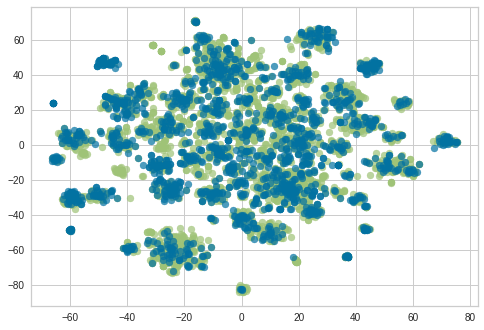

In [38]:
GraficaData(libCon,'TokenizeTweetsTidy_text')

In [34]:
# Ploting Learning Curve
# Creating CV training and test scores for various training set sizes
X, _, y, _, Tfidf_vect = separaData(libCon,'TokenizeTweetsTidy_text',1)
cv = StratifiedKFold(n_splits=10)
estimator = LogisticRegression(solver='saga',max_iter=100 , C=5)
train_sizes, train_scores, test_scores = learning_curve(estimator,X, y, cv=cv, scoring='f1_weighted', n_jobs=-1,train_sizes=np.linspace(0.3, 1.0, 10))

# Creating means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Creating means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig = go.Figure()

layout = go.Layout(title='Learning Curve Logistic Regression',
                   xaxis=dict(title='Training Set Size'),
                   yaxis=dict(title='Accuracy Score'))

fig = go.Figure(layout=layout)


fig.add_trace(go.Scatter(
    x=train_sizes, y=train_mean,
    line_color='rgb(230,171,2)',
    line = dict(width=4, dash='dash'),
    name='Training score',
))

fig.add_trace(go.Scatter(
    x=train_sizes, y=test_mean,
    line_color='rgb(117,112,179)',
    line = dict(width=4),
    mode='lines+markers',
    name='Cross-validation score',
    
))

fig.update_traces(mode='lines')
fig.write_html("LearningCurveRegLogistic.html")
fig.show()

In [35]:
# Ploting Learning Curve
# Creating CV training and test scores for various training set sizes
X, _, y, _, Tfidf_vect = separaData(libCon,'TokenizeTweetsTidy_text',1)
cv = StratifiedKFold(n_splits=10)
estimator = SVC(gamma=0.01, C=100,probability=True, kernel= 'rbf')
train_sizes, train_scores, test_scores = learning_curve(estimator,X, y, cv=cv, scoring='f1_weighted', n_jobs=-1,train_sizes=np.linspace(0.3, 1.0, 10))

# Creating means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Creating means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig = go.Figure()

layout = go.Layout(title='Learning Curve SVM',
                   xaxis=dict(title='Training Set Size'),
                   yaxis=dict(title='Accuracy Score'))

fig = go.Figure(layout=layout)


fig.add_trace(go.Scatter(
    x=train_sizes, y=train_mean,
    line_color='rgb(230,171,2)',
    line = dict(width=4, dash='dash'),
    name='Training score',
))

fig.add_trace(go.Scatter(
    x=train_sizes, y=test_mean,
    line_color='rgb(117,112,179)',
    line = dict(width=4),
    mode='lines+markers',
    name='Cross-validation score',
    
))

fig.update_traces(mode='lines')
fig.write_html("LearningCurveSVM.html")
fig.show()

Best Threshold=0.681871, G-Mean=0.708


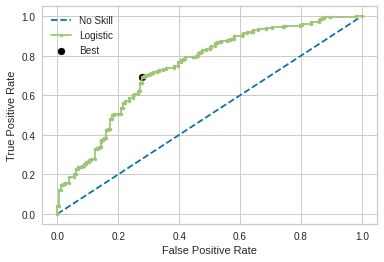

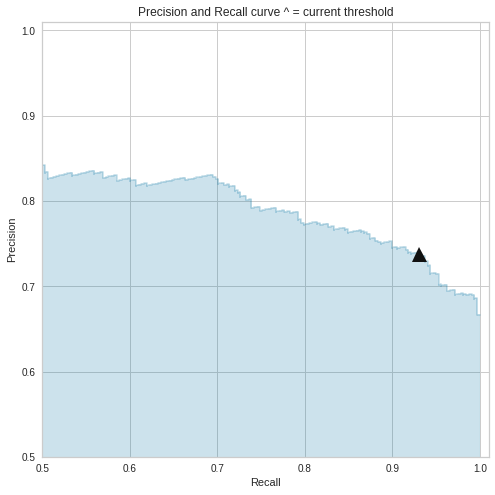

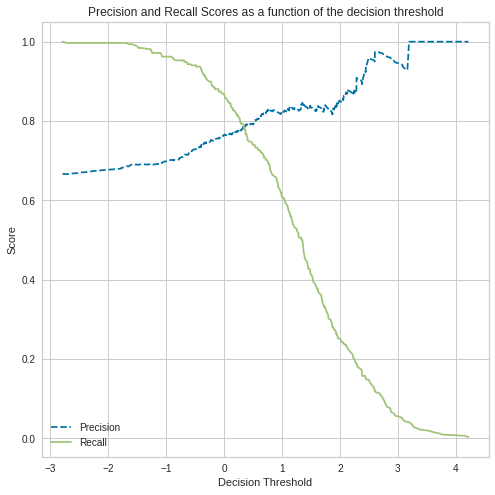

{'Liberales': {'precision': 0.5517241379310345, 'recall': 0.691358024691358, 'f1-score': 0.6136986301369863, 'support': 162}, 'Conservadores': {'precision': 0.8194945848375451, 'recall': 0.7138364779874213, 'f1-score': 0.7630252100840335, 'support': 318}, 'accuracy': 0.70625, 'macro avg': {'precision': 0.6856093613842897, 'recall': 0.7025972513393897, 'f1-score': 0.6883619201105099, 'support': 480}, 'weighted avg': {'precision': 0.7291220590065978, 'recall': 0.70625, 'f1-score': 0.712627489351905, 'support': 480}}


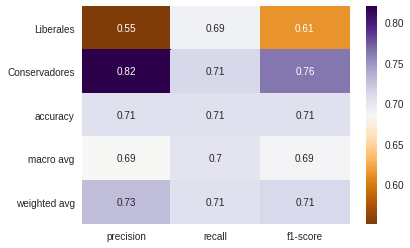

Best Threshold=0.691281, G-Mean=0.659


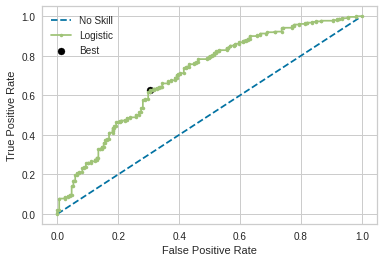

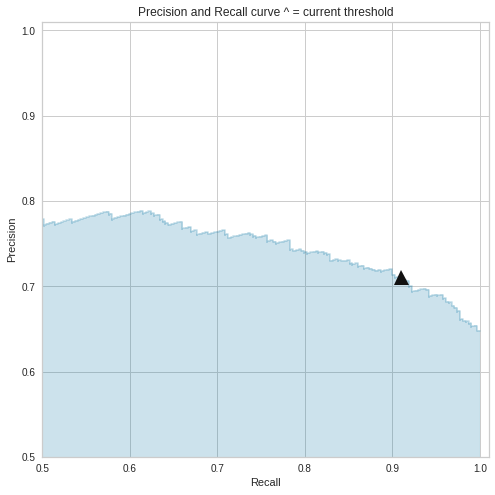

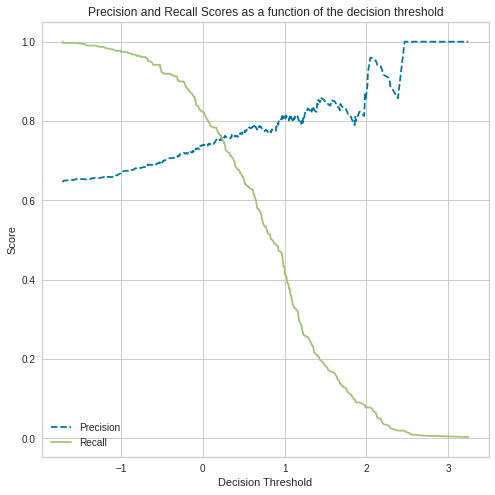

{'Liberales': {'precision': 0.484251968503937, 'recall': 0.7192982456140351, 'f1-score': 0.5788235294117646, 'support': 171}, 'Conservadores': {'precision': 0.7876106194690266, 'recall': 0.5760517799352751, 'f1-score': 0.6654205607476635, 'support': 309}, 'accuracy': 0.6270833333333333, 'macro avg': {'precision': 0.6359312939864817, 'recall': 0.6476750127746551, 'f1-score': 0.622122045079714, 'support': 480}, 'weighted avg': {'precision': 0.6795391000627135, 'recall': 0.6270833333333333, 'f1-score': 0.6345703683342496, 'support': 480}}


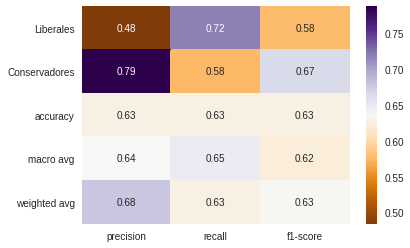

In [38]:
modelLogisticRegression = ModeloClasificadorKFoldCVThreshold(LogisticRegression, libConNoLem, "LogisticRegressionThresholdNoLem")
modelSVC = ModeloClasificadorKFoldCVThreshold(SVC, libConNoLem, "SVCThresholdNoLem")

0.7042831774081775
              precision    recall  f1-score   support

           0       0.57      0.44      0.50       151
           1       0.77      0.85      0.81       329

    accuracy                           0.72       480
   macro avg       0.67      0.65      0.65       480
weighted avg       0.71      0.72      0.71       480



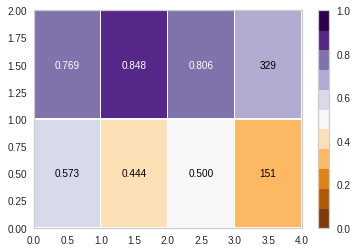

[[ 67  84]
 [ 50 279]]
<class 'numpy.ndarray'>


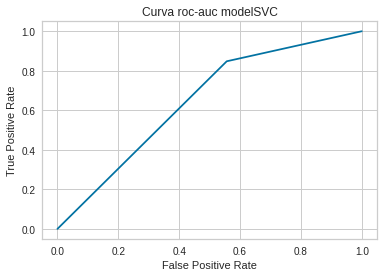

{'Liberales': {'precision': 0.5726495726495726, 'recall': 0.44370860927152317, 'f1-score': 0.5, 'support': 151}, 'Conservadores': {'precision': 0.768595041322314, 'recall': 0.8480243161094225, 'f1-score': 0.8063583815028901, 'support': 329}, 'accuracy': 0.7208333333333333, 'macro avg': {'precision': 0.6706223069859434, 'recall': 0.6458664626904729, 'f1-score': 0.653179190751445, 'support': 480}, 'weighted avg': {'precision': 0.7069538626356808, 'recall': 0.7208333333333333, 'f1-score': 0.7099831406551059, 'support': 480}}


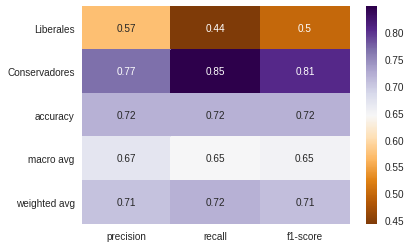

0.689505803880804
              precision    recall  f1-score   support

           0       0.61      0.45      0.52       168
           1       0.74      0.85      0.79       312

    accuracy                           0.71       480
   macro avg       0.68      0.65      0.66       480
weighted avg       0.70      0.71      0.70       480



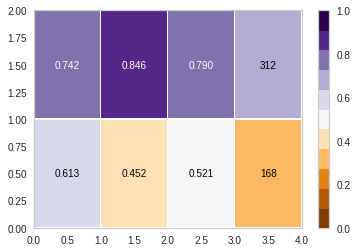

[[ 76  92]
 [ 48 264]]
<class 'numpy.ndarray'>


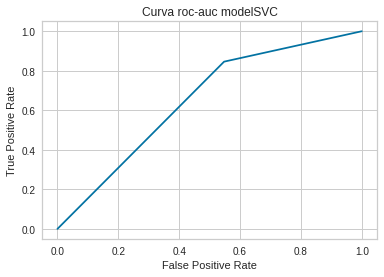

{'Liberales': {'precision': 0.6129032258064516, 'recall': 0.4523809523809524, 'f1-score': 0.5205479452054794, 'support': 168}, 'Conservadores': {'precision': 0.7415730337078652, 'recall': 0.8461538461538461, 'f1-score': 0.7904191616766467, 'support': 312}, 'accuracy': 0.7083333333333334, 'macro avg': {'precision': 0.6772381297571584, 'recall': 0.6492673992673993, 'f1-score': 0.655483553441063, 'support': 480}, 'weighted avg': {'precision': 0.6965386009423704, 'recall': 0.7083333333333334, 'f1-score': 0.6959642359117382, 'support': 480}}


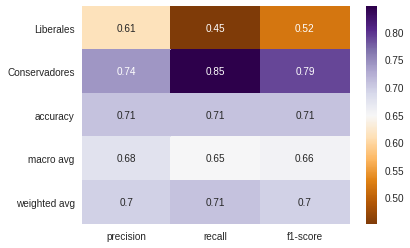

In [39]:
modelLogisticRegression = ModeloClasificadorKFoldCV(LogisticRegression, libConNoLem, "LogisticRegressionNoThresholdNoLem")
modelSVC = ModeloClasificadorKFoldCV(SVC, libConNoLem, "SVCNoThresholdNoLem")

0.7130444386694387
              precision    recall  f1-score   support

           0       0.64      0.39      0.49       170
           1       0.73      0.88      0.80       310

    accuracy                           0.71       480
   macro avg       0.69      0.64      0.64       480
weighted avg       0.70      0.71      0.69       480



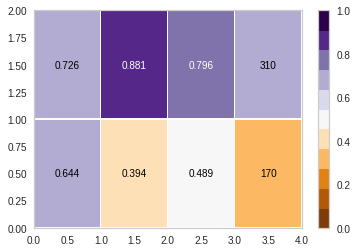

[[ 67 103]
 [ 37 273]]
<class 'numpy.ndarray'>


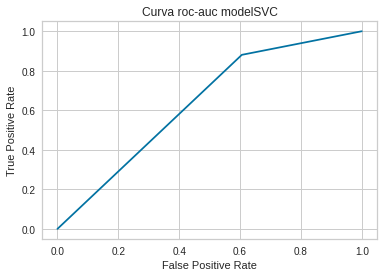

{'Liberales': {'precision': 0.6442307692307693, 'recall': 0.3941176470588235, 'f1-score': 0.4890510948905109, 'support': 170}, 'Conservadores': {'precision': 0.726063829787234, 'recall': 0.8806451612903226, 'f1-score': 0.7959183673469388, 'support': 310}, 'accuracy': 0.7083333333333334, 'macro avg': {'precision': 0.6851472995090017, 'recall': 0.637381404174573, 'f1-score': 0.6424847311187248, 'support': 480}, 'weighted avg': {'precision': 0.6970812875068194, 'recall': 0.7083333333333334, 'f1-score': 0.687236208351954, 'support': 480}}


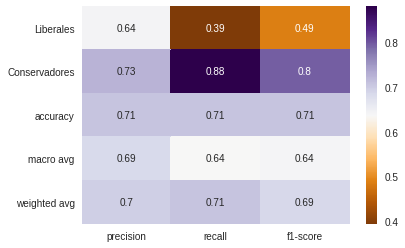

0.6930388080388081
              precision    recall  f1-score   support

           0       0.46      0.37      0.41       151
           1       0.73      0.80      0.77       329

    accuracy                           0.66       480
   macro avg       0.60      0.59      0.59       480
weighted avg       0.65      0.66      0.65       480



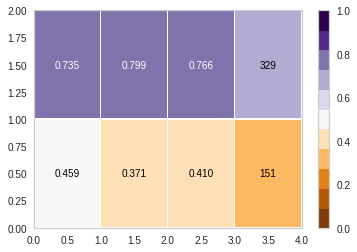

[[ 56  95]
 [ 66 263]]
<class 'numpy.ndarray'>


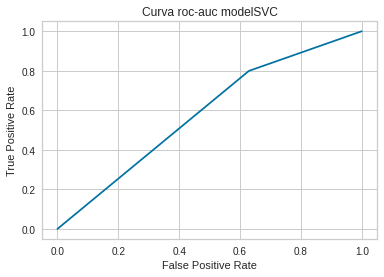

{'Liberales': {'precision': 0.45901639344262296, 'recall': 0.3708609271523179, 'f1-score': 0.4102564102564103, 'support': 151}, 'Conservadores': {'precision': 0.7346368715083799, 'recall': 0.7993920972644377, 'f1-score': 0.7656477438136827, 'support': 329}, 'accuracy': 0.6645833333333333, 'macro avg': {'precision': 0.5968266324755014, 'recall': 0.5851265122083777, 'f1-score': 0.5879520770350465, 'support': 480}, 'weighted avg': {'precision': 0.6479312627835271, 'recall': 0.6645833333333333, 'f1-score': 0.6538475534654574, 'support': 480}}


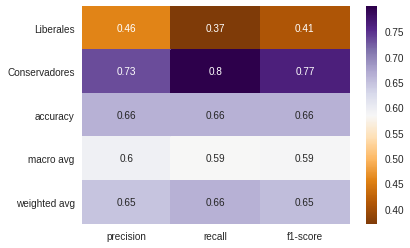

In [40]:
modelLogisticRegression = ModeloClasificadorKFoldCV(LogisticRegression, libCon, "LogisticRegressionNoThresholdConLem")
modelSVC = ModeloClasificadorKFoldCV(SVC, libCon, "SVCNoThresholdConLem")

In [10]:
modelSVCFinal = ModeloClasificadorFinal(SVC, libCon, "Maquina de vector de soportes")

In [12]:
filename = 'ModelSVM.pkl'
pickle.dump(modelSVCFinal, open(filename, 'wb'))

In [ ]:
df.to_csv('dfFinal.csv', encoding='utf-8')
libCon.to_csv('libCon.csv', encoding='utf-8')